# Comparison & Benchmarking
## Temporian vs. Pandas using variable-length moving windows

In this example, we'll use , which in this case consists of multi-day recordings of wrist-worn accelerometer, annotated with events that indicate sleeping periods.

To run this notebook, download the **[data from Kaggle](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states) and unzip it in `../data/child-mind-institute-detect-sleep-states`**. 
We'll use these files from it:
1. `train_events.csv` contains the annotated events: `onset`, the beginning of sleep, and `wakeup`, the end of sleep.
2. `train_series.parquet` contains two accelerometer signals sampled every 5 seconds, from which we'll use the `anglez` column, which refers to the angle of the arm relative to the vertical axis of the body.

Both sequences contain a `series_id` string, indicating each observed subject, and the `timestamp` for each event and measurement.

In [1]:
import temporian as tp
import numpy as np
import pandas as pd

## Dataframe 1: onset/wakeup events

In [2]:
from pathlib import Path
data_dir = Path("../data/child-mind-institute-detect-sleep-states")

# Dataframe with events
df_ev = pd.read_csv(data_dir / "train_events.csv")[["series_id", "event", "timestamp"]]
df_ev

,series_id,event,timestamp
0,038441c925bb,onset,2018-08-14T22:26:00-0400
1,038441c925bb,wakeup,2018-08-15T06:41:00-0400
2,038441c925bb,onset,2018-08-15T19:37:00-0400
3,038441c925bb,wakeup,2018-08-16T05:41:00-0400
4,038441c925bb,onset,2018-08-16T23:03:00-0400
...,...,...,...
14503,fe90110788d2,wakeup,2017-09-06T04:07:00-0400
14504,fe90110788d2,onset,2017-09-06T23:35:00-0400
14505,fe90110788d2,wakeup,2017-09-07T09:17:00-0400
14506,fe90110788d2,onset,NaN


## Dataframe 2: accelerometer signals

In [3]:
# Dataframe with signals
df_sig = pd.read_parquet(data_dir / "train_series.parquet", columns=["series_id", "timestamp", "anglez"])

# Pandas loads float32 by default but at some point converts to float64
df_sig = df_sig.astype({"anglez": np.float64})

In [4]:
df_sig

,series_id,timestamp,anglez
0,038441c925bb,2018-08-14T15:30:00-0400,2.636700
1,038441c925bb,2018-08-14T15:30:05-0400,2.636800
2,038441c925bb,2018-08-14T15:30:10-0400,2.637000
3,038441c925bb,2018-08-14T15:30:15-0400,2.636800
4,038441c925bb,2018-08-14T15:30:20-0400,2.636800
...,...,...,...
127946335,fe90110788d2,2017-09-08T00:14:35-0400,-27.277500
127946336,fe90110788d2,2017-09-08T00:14:40-0400,-27.032499
127946337,fe90110788d2,2017-09-08T00:14:45-0400,-26.841200
127946338,fe90110788d2,2017-09-08T00:14:50-0400,-26.723900


## Filter and plot example data

In [5]:
# Filter data to use in the benchmarks

ids = df_ev["series_id"].unique()[:25]

df_events = df_ev[df_ev["series_id"].isin(ids) & df_ev["timestamp"].notnull()]
df_signals = df_sig[df_sig["series_id"].isin(ids) & df_sig["timestamp"].notnull()]

The number of plots (25) is larger than "options.max_num_plots=5". Only the first plots will be printed.


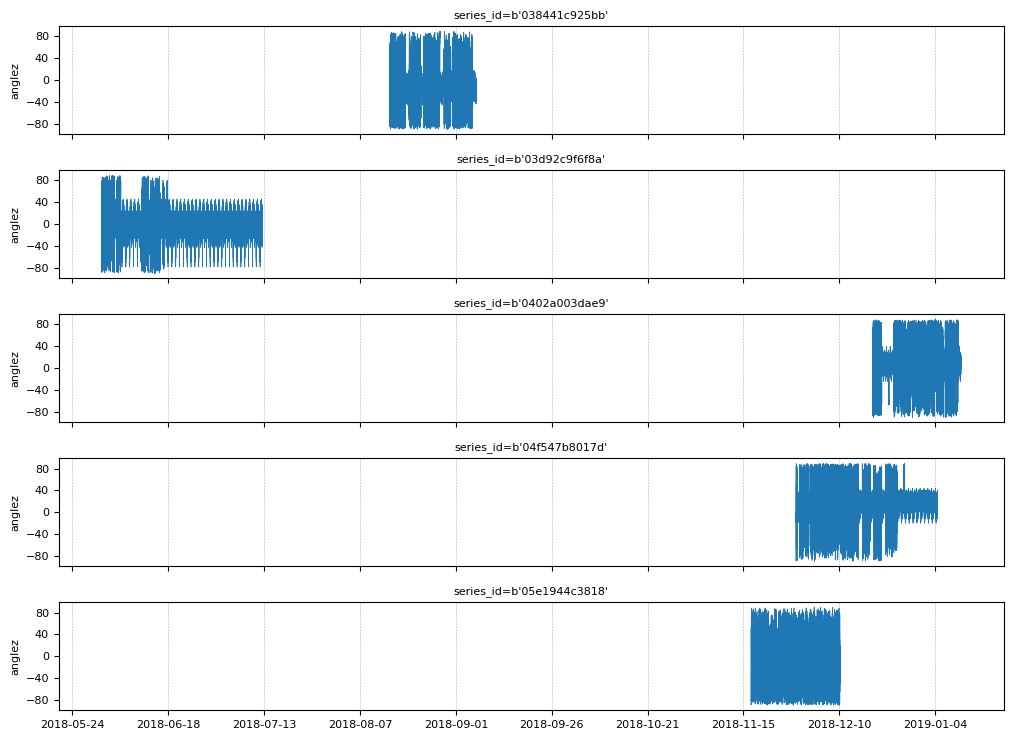

In [6]:
sig_evset = tp.from_pandas(df_signals[["series_id", "timestamp", "anglez"]], indexes=["series_id"])
sig_evset.plot(max_num_plots=5)

The number of plots (24) is larger than "options.max_num_plots=5". Only the first plots will be printed.


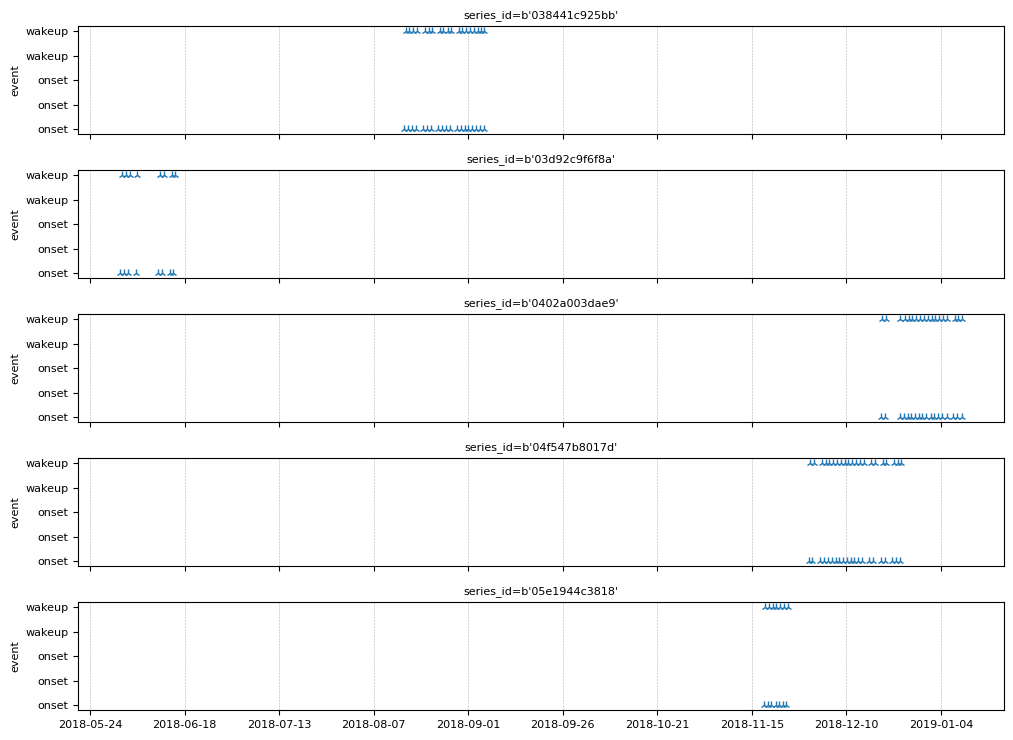

In [7]:
events_evset = tp.from_pandas(df_events[["series_id", "event", "timestamp"]], indexes=["series_id"])
events_evset.plot(max_num_plots=5)

## Example use case for benchmarking

For this benchmark, we'll simply try to calculate the average and standard deviation of the accelerometer signal for each "night" or sleeping period, which is the interval between `onset` and `wakeup` events.

For this, we need to use the data from one dataframe to get the onset/wakeup events, and use those timestamps as the limits to calculate avg/std over the accelerometer signal, stored in the other dataframe.

### Pandas code

In [8]:
%%time

# Remove potential "onset" events without a subsequent "wakeup"
df_events = df_events.sort_values(by=["series_id", "timestamp"])
valid_events = df_events["event"] != df_events["event"].shift(-1)
df_valid_events = df_events[valid_events]

# Combine signals + events (onset/wakeup) and sort
df_combined = pd.concat([df_valid_events, df_signals])
df_combined = df_combined.sort_values(by=["series_id", "timestamp"])

# Flag together all data points between onset/wakeup events
df_combined["event_id"] = df_combined["event"].notnull().cumsum()

# Remove even event_ids, to get only rows between 'onset' and 'wakeup'
df_nights = df_combined.loc[df_combined["event_id"] % 2 != 0]

# Remove onset/wakeup events, get only "anglez" rows
df_nights = df_nights[df_nights["anglez"].notnull()]

# Duplicate/rename anglez col and aggregate as average and std
df_nights = df_nights.assign(std_anglez=df_nights.anglez, avg_anglez=df_nights.anglez)
df_means = df_nights.groupby(["series_id", "event_id"]).aggregate({"avg_anglez": "mean", "std_anglez": "std", "timestamp": "max"})

# Remove hierarchical index after groupby
df_result = df_means.reset_index()

CPU times: user 15 s, sys: 1.12 s, total: 16.1 s
Wall time: 16 s


In [9]:
print(f"Valid events: {valid_events.sum()} / {len(valid_events)}")

Valid events: 860 / 861


## Temporian code

In [10]:
%%time

# Separate onset/wakeup events
onset = events_evset.filter(events_evset["event"].equal("onset"))
wakeup = events_evset.filter(events_evset["event"].equal("wakeup"))

# Step on each "wakeup" event, and get time since last "onset"
sleeping_windows = onset.since_last(sampling=wakeup)

# Calculate avg/std for each sleeping window
avg_per_sleep = sig_evset.simple_moving_average(window_length=sleeping_windows)
std_per_sleep = sig_evset.moving_standard_deviation(window_length=sleeping_windows)

# Put together avg/std
sleep_metrics = tp.glue(avg_per_sleep.prefix("avg_"), std_per_sleep.prefix("std_"))

CPU times: user 251 ms, sys: 61 ms, total: 312 ms
Wall time: 312 ms


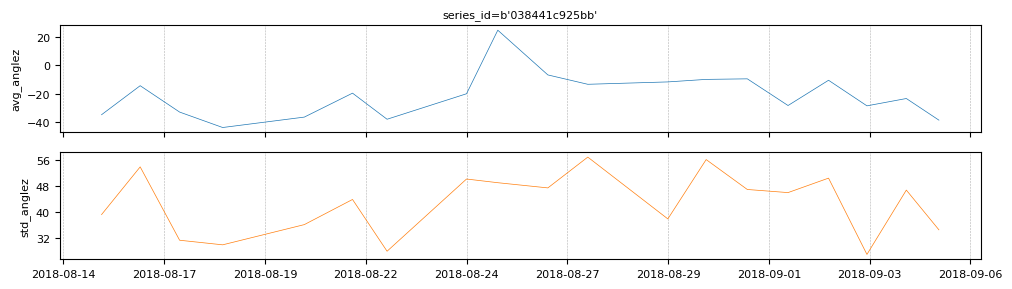

In [11]:
sleep_metrics.plot(indexes=["038441c925bb"], style='line')

## Verification of results

Let's check that all the results are close using both libraries. There might be small numerical differences in the calculations, but we still need to verify that the results make sense.

In [12]:
values_temporian = tp.to_pandas(sleep_metrics)\
                     .sort_values(by=["series_id", "timestamp"])[["avg_anglez", "std_anglez"]]\
                     .to_numpy()

values_pandas = df_result.sort_values(by=["series_id", "timestamp"])[["avg_anglez", "std_anglez"]]\
                         .to_numpy()

# Check that all values are close enough
(abs(values_temporian - values_pandas) < 0.1).all()

True

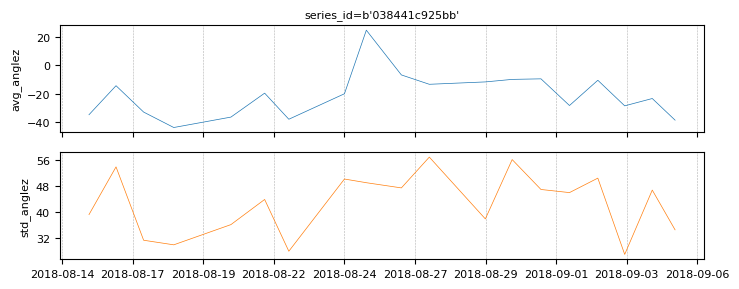

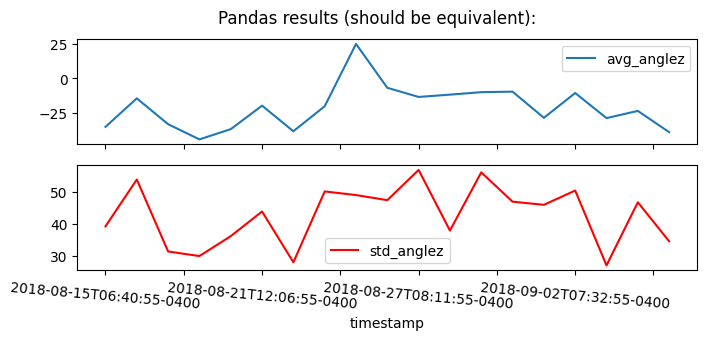

In [13]:
import matplotlib.pyplot as plt

# Select one series to plot
series_id = "038441c925bb"
# series_id = "0cd1e3d0ed95"
# series_id = "137771d19ca2"

# Temporian plot
sleep_metrics.plot(indexes=[series_id], style='line', width_px=750)

# Pandas plot
df_series = df_result[df_result["series_id"] == series_id]
fig, axes = plt.subplots(nrows=2, figsize=(8, 3), sharex=True)
fig.suptitle("Pandas results (should be equivalent):")
df_series.plot(x="timestamp", y="avg_anglez", ax=axes[0])
df_series.plot(x="timestamp", y="std_anglez", c='r', ax=axes[1])
_ = plt.xticks(rotation=-5)


## Analysis of results

Temporian code is shorter, very easy to understand, more robust and way faster for this use case.

The execution time gap in this case is not only relevant as an "optimization" step but also for EDA purposes, since Temporian is almost instantaneous while Pandas takes ~15 seconds, being still comfortable to use with amounts of data where pandas is very slow and likely to run out of memory.

### Note about the robustness of the code
Did you notice the first lines of Pandas code, in which we remove invalid `onset` events that are not be followed by a `wakeup`?

This workaround fixes an issue with Pandas that only popped up when using the first 25 `series_id` values insted of a smaller subset (first 10 series) that we were using to iterate faster during development (which is a very common practice). The fact that there was one single row with two consecutive `onset` events, shifted all the following rows causing the Pandas code to break badly. And we only noticed the issue because the results didn't match with Temporian during verification.

This example illustrates a very frequent issue, in which some assumptions about the structure of the data can lead to catastrophic bugs when those assumptions are no longer true. And even though the magnitude of errors might be very large, these bugs might go unnoticed because the code runs silently, unless those edge cases were explicitly considered and defensive code is in place.

This is why we say that Temporian tends to be more "robust" for temporal data: since the API is specifically designed for it, the meaning (or "semantics") of the code tends to be easier to grasp, and potential issues can be anticipated earlier. Also, it's designed to avoid implicit behavior that leads to silent bugs, so if there's any assumption about the data that is relevant to the process and no longer holds (e.g: non-matching data types, null timestamps, value overflow), Temporian's code will very likely raise an error instead of producing wrong values.